# Trend Convexity

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_process import ArmaProcess

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
src_path = os.path.join(parent_path, "src")
hf_path = os.path.join(data_path, "hf_indices.parquet")
spx_path = os.path.join(data_path, "spx.parquet")
futures_path = os.path.join(data_path, "futures.parquet")

# Import Class Methods

In [3]:
sys.path.append(src_path)
from Heteroskedasticity import *

# Read in data

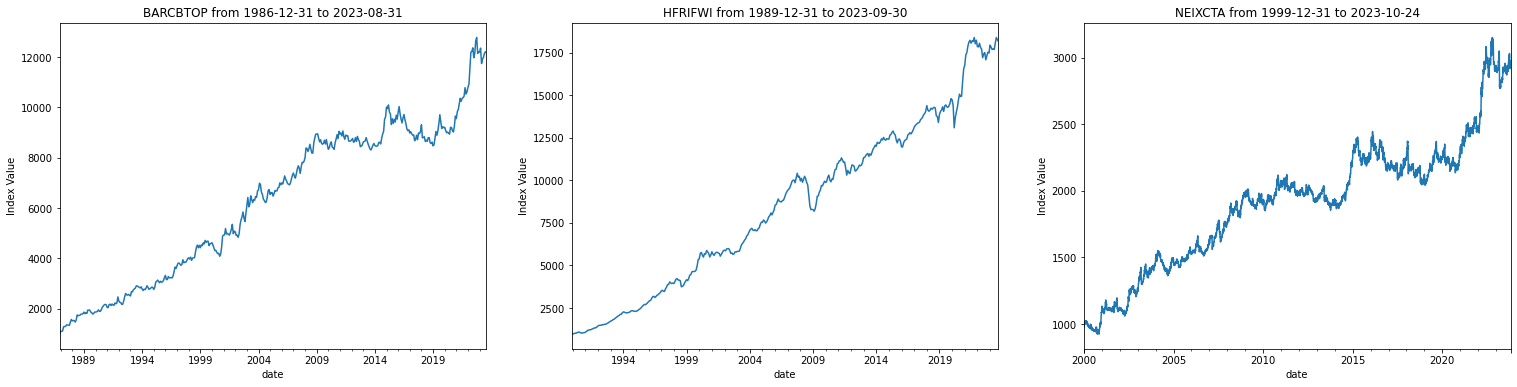

In [4]:
df_hf = (pd.read_parquet(
    path = hf_path, engine = "pyarrow").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

tickers = df_hf.security.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(tickers), figsize = (26,6))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_hf.query(
        "security == @ticker").
        drop(columns = ["security"]).
        set_index("date").
        rename(columns = {"PX_LAST": ticker}))
    
    (df_tmp.plot(
        ax = axes[i],
        legend = False,
        ylabel = "Index Value",
        title = "{} from {} to {}".format(
            ticker, 
            df_tmp.index.min().date(),
            df_tmp.index.max().date())))

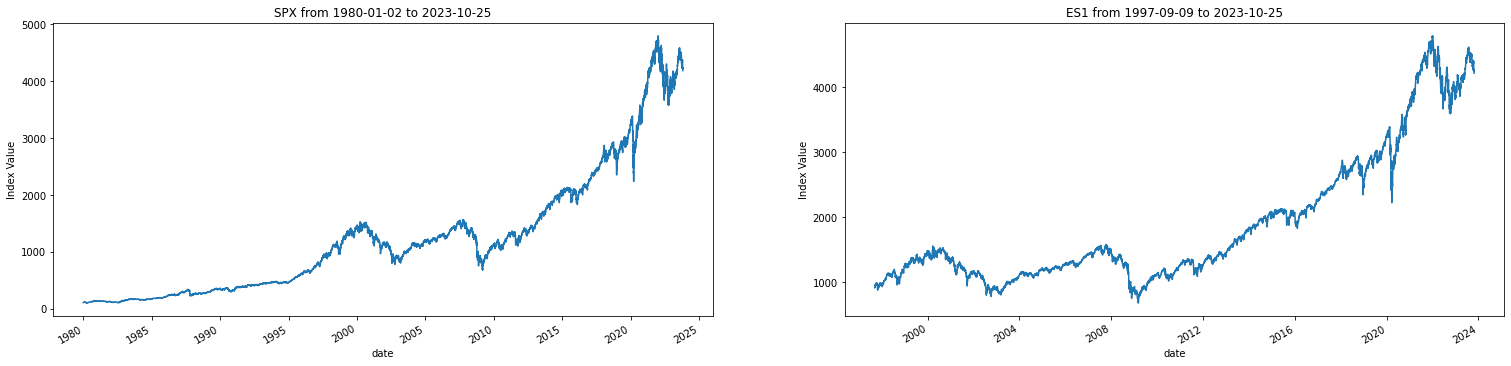

In [5]:
df_spx = (pd.read_parquet(
    path = spx_path, engine = "pyarrow").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

tickers = df_spx.security.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(tickers), figsize = (26,6))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_spx.query(
        "security == @ticker").
        drop(columns = ["security"]).
        set_index("date").
        rename(columns = {"PX_LAST": ticker}))
    
    (df_tmp.plot(
        ax = axes[i],
        legend = False,
        ylabel = "Index Value",
        title = "{} from {} to {}".format(
            ticker, 
            df_tmp.index.min().date(),
            df_tmp.index.max().date())))

# Introduction

In [6]:
def _pct_change(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "date").
        assign(
            index_rtn = lambda x: x.PX_LAST.pct_change(),
            spx_rtn = lambda x: x.SPX.pct_change()))

df_hf_monthly = (df_hf.query(
    "security != 'NEIXCTA'").
    assign(month_year = lambda x: x.date.dt.month.astype(str) + "-" + x.date.dt.year.astype(str)).
    drop(columns = ["date"]))

df_spx_monthly = (df_spx.query(
    "security == 'SPX'").
    set_index("date").
    drop(columns = ["security"]).
    resample("M").
    last().
    reset_index().
    assign(month_year = lambda x: x.date.dt.month.astype(str) + "-" + x.date.dt.year.astype(str)).
    drop(columns = ["date"]).
    rename(columns = {"PX_LAST": "SPX"}))

df_rtn = (df_hf_monthly.merge(
    right = df_spx_monthly, how = "inner", on = ["month_year"]).
    assign(date = lambda x: pd.to_datetime(x.month_year)).
    drop(columns = "month_year").
    groupby("security").
    apply(_pct_change).
    dropna())

Starting with the HF Equal Weight Return

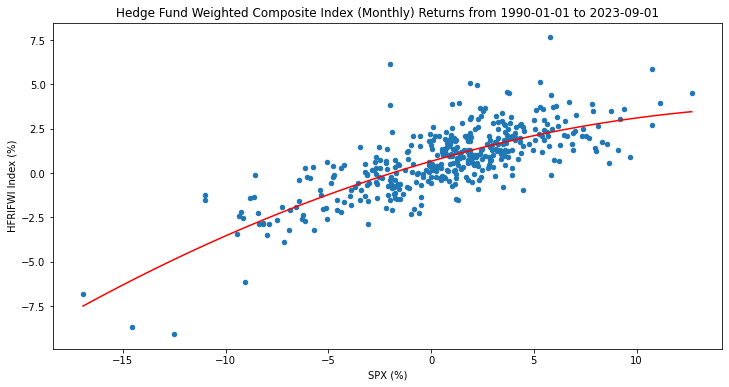

In [7]:
fig, axes = plt.subplots(figsize = (12,6))

df_hfrifwi = (df_rtn.query(
    "security == 'HFRIFWI'").
    assign(
        spx_rtn = lambda x: x.spx_rtn * 100,
        index_rtn = lambda x: x.index_rtn * 100))

poly_model = np.poly1d(np.polyfit(
    x = df_hfrifwi.spx_rtn,
    y = df_hfrifwi.index_rtn,
    deg = 2))

x = np.linspace(start = df_hfrifwi.spx_rtn.min(), stop = df_hfrifwi.spx_rtn.max(), num = 2_000)
y = poly_model(x)
                          
(df_hfrifwi.plot(
    kind = "scatter", x = "spx_rtn", y = "index_rtn",
    ylabel = "HFRIFWI Index (%)",
    xlabel = "SPX (%)",
    ax = axes,
    title = "Hedge Fund Weighted Composite Index (Monthly) Returns from {} to {}".format(
        df_hfrifwi.date.min().date(),
        df_hfrifwi.date.max().date())))

axes.plot(x, y, color = "r")

plt.show()

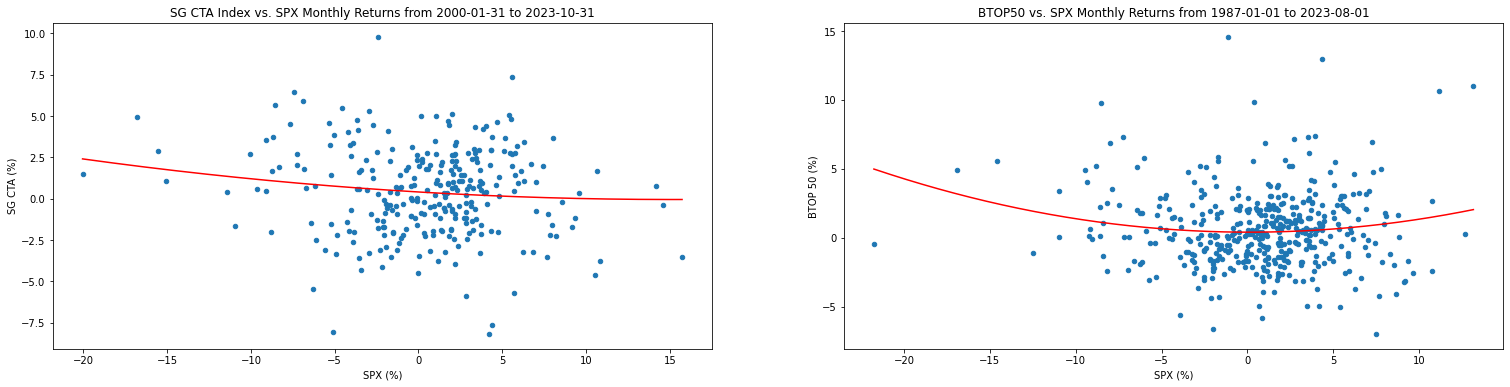

In [8]:
fig, axes = plt.subplots(ncols = 2, figsize = (26,6))

df_sg = (pd.concat(
    [df_hf.query("security == 'NEIXCTA'"), df_spx.query("security == 'SPX'")]).
    pivot(index = "date", columns = "security", values = "PX_LAST").
    resample("M").
    first().
    pct_change().
    dropna() * 
    100)

poly_model = np.poly1d(np.polyfit(
    x = df_sg.SPX,
    y = df_sg.NEIXCTA,
    deg = 2))

x = np.linspace(start = df_sg.SPX.min(), stop = df_sg.SPX.max(), num = 2_000)
y = poly_model(x)

(df_sg.plot(
    ax = axes[0],
    kind = "scatter",
    x = "SPX", y = "NEIXCTA",
    xlabel = "SPX (%)",
    ylabel = "SG CTA (%)",
    title = "SG CTA Index vs. SPX Monthly Returns from {} to {}".format(
        df_sg.index.min().date(),
        df_sg.index.max().date())))

axes[0].plot(x,y, color = "r")

df_barcbtop = df_rtn.query("security == 'BARCBTOP'").set_index("date") * 100

poly_model = np.poly1d(np.polyfit(
    x = df_barcbtop.spx_rtn,
    y = df_barcbtop.index_rtn,
    deg = 2))

x = np.linspace(start = df_barcbtop.spx_rtn.min(), stop = df_barcbtop.spx_rtn.max(), num = 2_000)
y = poly_model(x)
               
(df_barcbtop.plot(
    kind = "scatter",
    ax = axes[1],
    x = "spx_rtn", y = "index_rtn",
    xlabel = "SPX (%)",
    ylabel = "BTOP 50 (%)",
    title = "BTOP50 vs. SPX Monthly Returns from {} to {}".format(
        df_barcbtop.index.min().date(),
        df_barcbtop.index.max().date())))

axes[1].plot(x,y, color = "r")
plt.show()

# A toy model for the trend

In [9]:
df_spx = (pd.read_parquet(
    path = spx_path, engine = "pyarrow").
    assign(
        security = lambda x: x.security.str.split(" ").str[0],
        Dt = lambda x: x.PX_LAST - x.PX_LAST.shift(1)).
    dropna())

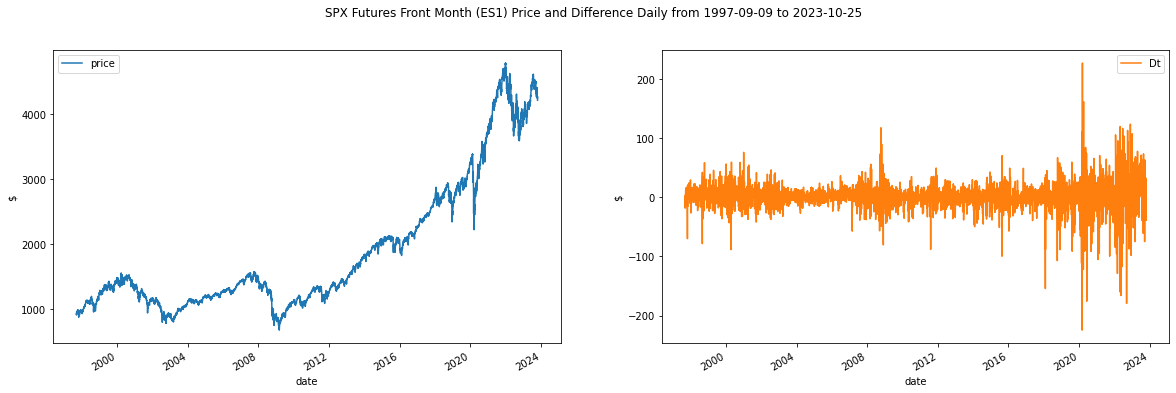

In [10]:
df_spx_prep = (df_spx.query(
    "security == 'ES1'").
    drop(columns = ["security"]).
    set_index("date").
    rename(columns = {"PX_LAST": "price"}))

(df_spx_prep.plot(
    figsize = (20,6),
    subplots = True,
    layout = (1,2),
    ylabel = "$",
    title = "SPX Futures Front Month (ES1) Price and Difference Daily from {} to {}".format(
        df_spx_prep.index.min().date(),
        df_spx_prep.index.max().date())))

plt.show()

First start by normalizing returns by exponential moving average of realized volatility with respect to $\tau_{\sigma}$ timeframe. The author later sets this to 10 which will be used through the whole repo. 

In [11]:
df_spx_vol = (df_spx_prep.assign(
    realized_vol = lambda x: x.Dt.rolling(window = 10, win_type = "exponential").std().shift(1),
    rt = lambda x: x.Dt / x.realized_vol).
    dropna())

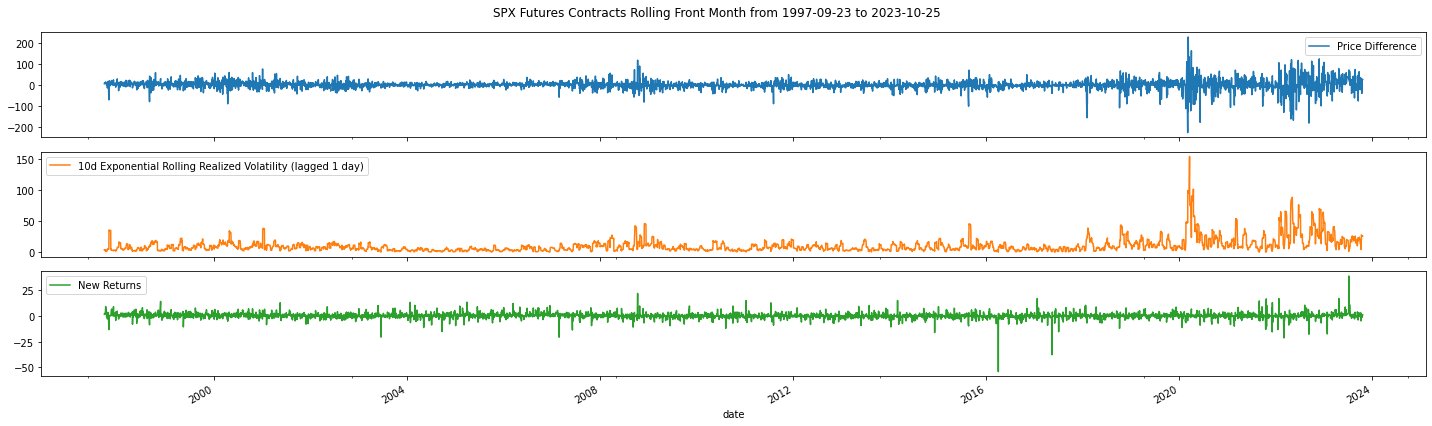

In [12]:
(df_spx_vol[
    ["Dt", "realized_vol", "rt"]].
    rename(columns = {
        "Dt": "Price Difference",
        "realized_vol": "10d Exponential Rolling Realized Volatility (lagged 1 day)",
        "rt": "New Returns"}).
    plot(
        subplots = True,
        figsize = (20,6),
        title = "SPX Futures Contracts Rolling Front Month from {} to {}".format(
            df_spx_vol.index.min().date(),
            df_spx_vol.index.max().date())))

plt.tight_layout()
plt.show()

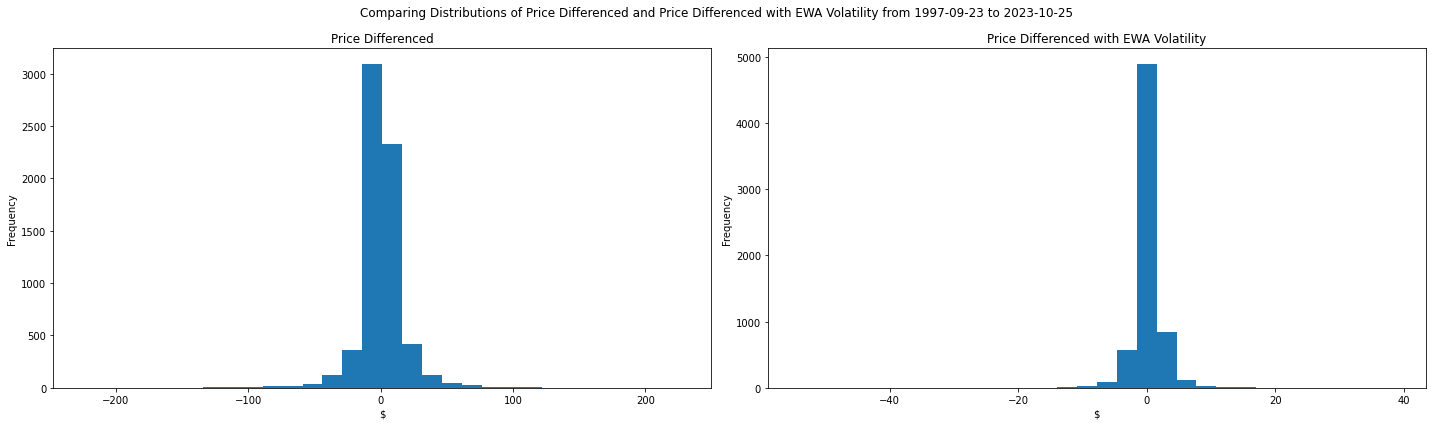

In [13]:
df_spx_vol

cols = ["Dt", "rt"]
col_renamer = ["Price Differenced", "Price Differenced with EWA Volatility"]
fig, axes = plt.subplots(ncols = len(cols), figsize = (20,6))
for i, col in enumerate(cols):
    
    (df_spx_vol[
        col].
        plot(
            kind = "hist",
            ax = axes[i],
            bins = 30,
            title = col_renamer[i]))
    
    axes[i].set_xlabel("$")
    
fig.suptitle("Comparing Distributions of Price Differenced and Price Differenced with EWA Volatility from {} to {}".format(
    df_spx_vol.index.min().date(),
    df_spx_vol.index.max().date()))

plt.tight_layout()
plt.show()

We have the following set of equations to work out the heteroskedasticity of the daily differences <br>
\begin{equation}
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_{\sigma}} \left[D_t^2 \right]} \\
L_{\tau}\left[X_t \right] := (1-\alpha) \sum_{i \leq t} \alpha^{(t-i)} X_i \\
\alpha = 1 - \frac{2}{\tau + 1}
\end{equation}
The paper also states that the following variables where used $\gamma = 1.05$ and $\tau_{\sigma} = 10$

Later thes functions were turned into methods and ran within a py script to save time. In this case the function will run within the notebook and save to file, then always try and read file first rather than recompute results

In [14]:
ewa_path = os.path.join(data_path, "ewa_vol.parquet")

try: 
    
    df_ewa = pd.read_parquet(path = ewa_path, engine = "pyarrow")
    print("Read from file")
    
except: 
    
    print("Failed to find file, computing EWA Volatility")
    Xt = df_spx_vol.Dt
    ewa_sigma = Heteroskedasticity().sigmat(Xt)
    df_ewa = df_spx_vol.merge(right = ewa_sigma.to_frame().rename(columns = {0: "ewa_sigma"}), how = "inner", on = ["date"])
    df_ewa.to_parquet(path = ewa_path, engine = "pyarrow")
    print("Computation Completed and saved to file")

Read from file


In [15]:
df_rt = (df_ewa.assign(
    rt_ewa = lambda x: x.Dt / x.ewa_sigma.shift(1)).
    dropna())

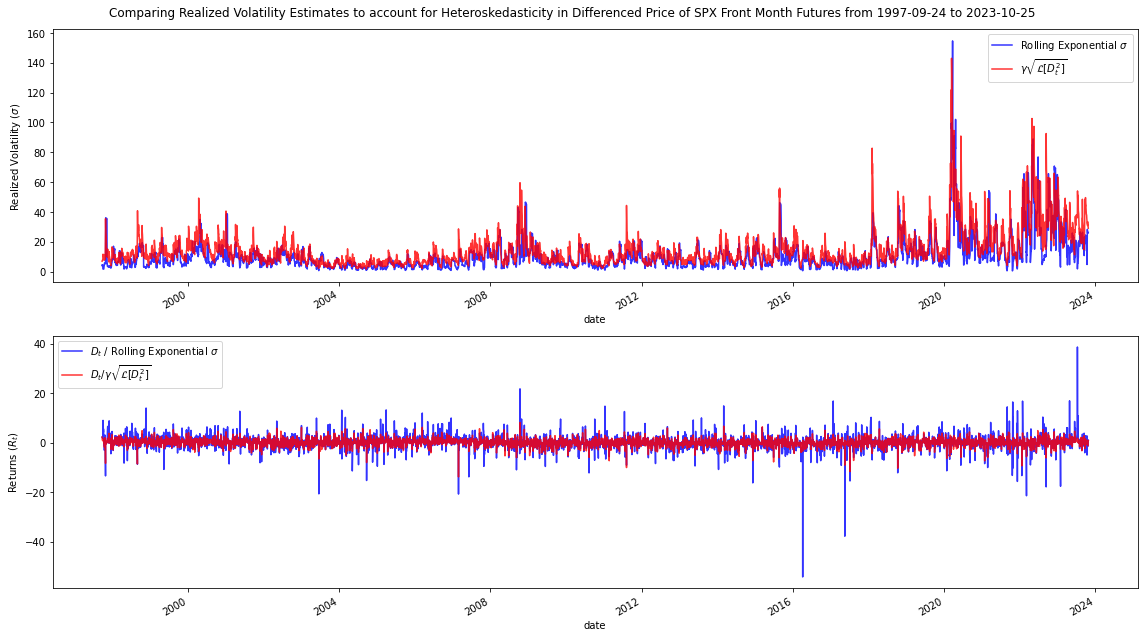

In [16]:
fig, axes = plt.subplots(nrows = 2, figsize = (16,9))

(df_rt[
    ["realized_vol", "ewa_sigma"]].
    rename(columns = {
        "realized_vol": "Rolling Exponential $\sigma$",
        "ewa_sigma": "$\gamma \sqrt{\mathcal{L}[D_t^2]} $"}).
    plot(
        ax = axes[0],
        color = ["blue", "red"],
        ylabel = "Realized Volatility ($\sigma$)",
        alpha = 0.8))

(df_rt[
    ["rt", "rt_ewa"]].
    rename(columns = {
        "rt": "$D_t$ / Rolling Exponential $\sigma$",
        "rt_ewa": "$D_t / \gamma \sqrt{\mathcal{L}[D_t^2]}$"}).
    plot(
        ax = axes[1],
        color = ["blue", "red"],
        ylabel = "Returns ($R_t$)",
        alpha = 0.8))

fig.suptitle("Comparing Realized Volatility Estimates to account for Heteroskedasticity in Differenced Price of SPX Front Month Futures from {} to {}".format(
    df_rt.index.min().date(),
    df_rt.index.max().date()))
plt.tight_layout()

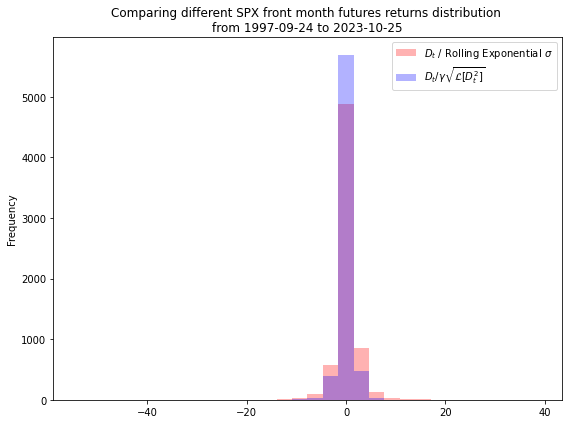

In [17]:
(df_rt[
    ["rt", "rt_ewa"]].
    rename(columns = {
        "rt": "$D_t$ / Rolling Exponential $\sigma$",
        "rt_ewa": "$D_t / \gamma \sqrt{\mathcal{L}[D_t^2]}$"}).
    plot(
        kind = "hist",
        bins = 30,
        color = ["red", "blue"],
        alpha = 0.3,
        xlabel = "$R_t",
        figsize = (8,6),
        title = "Comparing different SPX front month futures returns distribution \nfrom {} to {}".format(
            df_rt.index.min().date(),
            df_rt.index.max().date())))

plt.tight_layout()
plt.show()

## Trend following using EMAs

\begin{equation}
\mathcal{L}_{\tau'}[G_t] = \frac{\lambda \tau}{\tau - 1} \left(\tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau}[R_t^2] \right) \newline
\tau' = \frac{\tau}{2} + \frac{1}{2\tau} \approx \frac{\tau}{2} \newline
\mathcal{G}_t := \tau' \mathcal{L}_{\tau'}[G_t]
\end{equation} 

To make this plot we need both of these values $\mathcal{G}$ and $\mathcal{T}$. Those are defined by 
\begin{equation}
\mathcal{G_t}:= \tau' \mathcal{L}_{\tau'}[G_t] \newline
\mathcal{T} := \sqrt{\tau} \mathcal{L}_{\tau}[R_t]
\end{equation}

Need to organize functions and then rebuild this

In [18]:
trend_path = os.path.join(data_path, "trend.parquet")

try: df_combined = pd.read_parquet(path = trend_path, engine = "pyarrow")

except: 
    
    Rt = df_rt.rt
    tau = 180
    lambda_val = 0.01 / np.sqrt(tau)
    tau_prime = (tau / 2) + (1 / (2 * tau))

    df_Ltau = Heteroskedasticity().Ltau(Xt = Rt, tau = 180, verbose = True)
    T = Heteroskedasticity().past_trend(Xt = Rt, tau = 180, verbose = True)

    df_combined = (df_Ltau.to_frame().rename(
        columns = {0: "pnl"}).
        merge(right = T.to_frame(), how = "inner", on = "date").
        rename(columns = {0: "past_trend"}).
        assign(pnl = lambda x: x.pnl * 100))
    
    df_combined.to_parquet(path = trend_path, engine = "pyarrow")

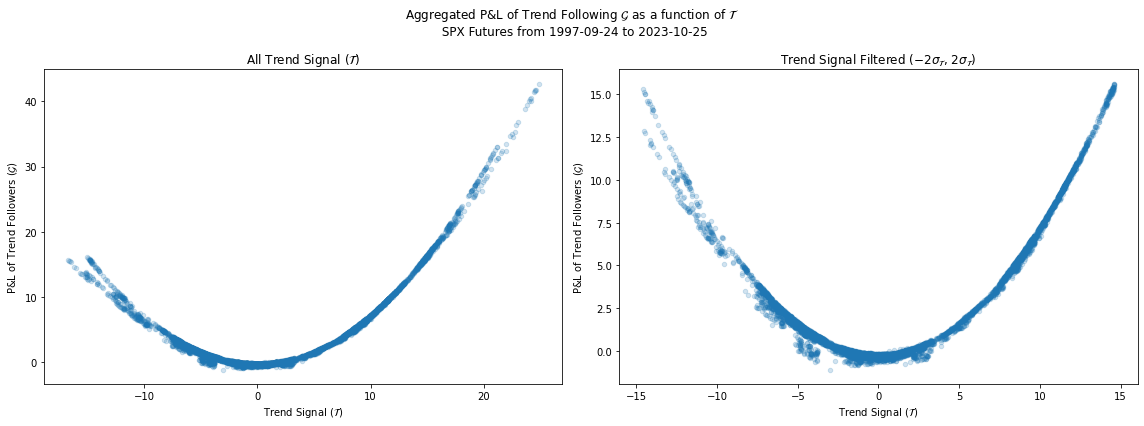

In [19]:
title = "Aggregated P&L of Trend Following $\mathcal{G}$ as a function of $\mathcal{T}$"

fig, axes = plt.subplots(ncols = 2, figsize = (16,6))

(df_combined.plot(
    kind = "scatter", 
    x = "past_trend", xlabel = "Trend Signal ($\mathcal{T}$)", 
    y = "pnl", ylabel = "P&L of Trend Followers ($\mathcal{G}$)",
    alpha = 0.2,
    ax = axes[0],
    title = "All Trend Signal ($\mathcal{T})$"))

(df_combined.assign(
    neg_cutoff = lambda x: -2 * x.past_trend.std(),
    pos_cutoff = lambda x: 2 * x.past_trend.std()).
    query("past_trend > neg_cutoff & past_trend < pos_cutoff").
    plot(
        kind = "scatter",
        x = "past_trend", xlabel = "Trend Signal $(\mathcal{T})$",
        y = "pnl", ylabel = "P&L of Trend Followers $(\mathcal{G}$)",
        alpha = 0.2,
        ax = axes[1],
        title = "Trend Signal Filtered ($ - 2\sigma_{\mathcal{T}}$, $2\sigma_{\mathcal{T}}$)"))

fig.suptitle("{}\n SPX Futures from {} to {}".format(
    title,
    df_combined.index.min().date(),
    df_combined.index.max().date()))

plt.tight_layout()
plt.show()